# To download Kepler-7 data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurve
from scipy.stats import binned_statistic
from astropy.stats import sigma_clip, mad_std
from astropy.constants import R_jup, R_sun
import astropy.units as u

In [2]:
t0 = 2454967.27687  # Esteves et al. 2015
period = 4.8854892  # Esteves et al. 2015
T_s = 5933  # NASA Exoplanet Archive
rp = 1.622 * R_jup  # Esteves et al. 2015
rstar = 1.966 * R_sun  # ±0.013 (NASA Exoplanet Archive)
duration = 5.1313 / 24  # Morton et al. 2016
a = 0.06067 * u.AU  # Esteves et al. 2015
b = 0.5599  # Esteves et al. 2015 +0.0045-0.0046
rho_star = 0.238 * u.g / u.cm ** 3  # Southworth et al. 2012 ±0.010
a_rs = float(a / rstar)
a_rp = float(a / rp)
rp_rstar = float(rp / rstar)
eclipse_half_dur = duration / period / 2

In [3]:
# The code below downloads the Kepler data
lcf = search_lightcurve(
    "Kepler-7", mission="Kepler", cadence="long",
).download_all()

slc = lcf.stitch().remove_nans()

In [4]:
tim, fl, fle = np.asarray(slc.time.jd), np.asarray(slc.flux), np.asarray(slc.flux_err)
print('Duration of the observations: {:.4f} days'.format(np.ptp(tim)))

Duration of the observations: 1470.4623 days


Text(0, 0.5, 'Relative Flux')

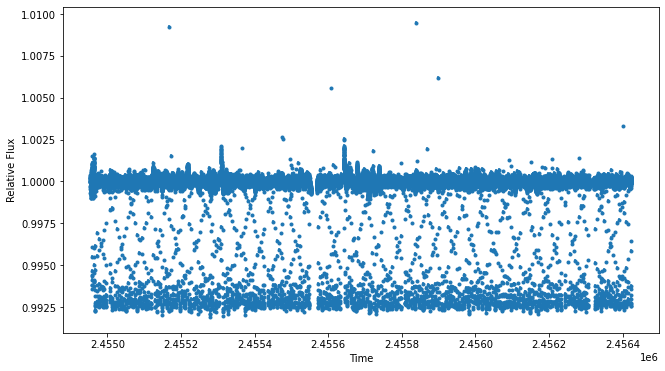

In [5]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim, fl, yerr=fle, fmt='.')
plt.xlabel('Time')
plt.ylabel('Relative Flux')

Lot's of data... and that's what that pattern, but it's just an illusion. There is no pattern.

Text(0, 0.5, 'Relative Flux')

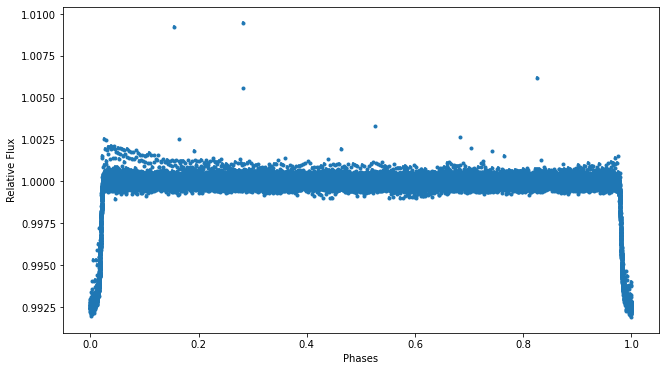

In [6]:
phases = ((slc.time.jd - t0) % period) / period

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(phases, fl, yerr=fle, fmt='.')
plt.xlabel('Phases')
plt.ylabel('Relative Flux')

Text(0, 0.5, 'Relative Flux')

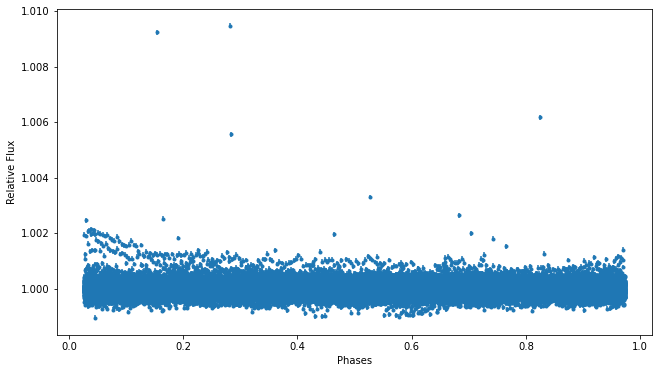

In [7]:
in_eclipse = np.abs(phases - 0.5) < eclipse_half_dur
in_transit = (phases < 1.2 * eclipse_half_dur) | (
            phases > 1 - 1.2 * eclipse_half_dur)

out_of_transit = np.logical_not(in_transit)    # This gives the indices of out-of-transit points

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(phases[out_of_transit], fl[out_of_transit], yerr=fle[out_of_transit], fmt='.')
plt.xlabel('Phases')
plt.ylabel('Relative Flux')

Now, sigma clipping points...

<ErrorbarContainer object of 3 artists>

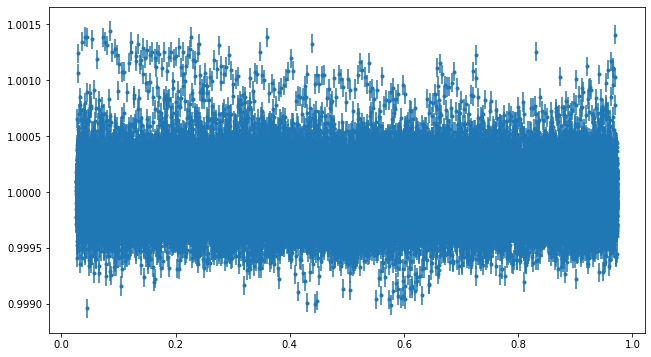

In [8]:
sc = sigma_clip(
    np.ascontiguousarray(slc.flux[out_of_transit], dtype=np.float64),
    maxiters=100, sigma=8, stdfunc=mad_std
)

phase = np.ascontiguousarray(phases[out_of_transit][~sc.mask], dtype=np.float64)
time = np.ascontiguousarray(slc.time.jd[out_of_transit][~sc.mask],
                            dtype=np.float64)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(phase, fl[out_of_transit][~sc.mask], yerr=fle[out_of_transit][~sc.mask], fmt='.')

Okay, so everything out of eclipse is masked and also sigma clipping is performed.

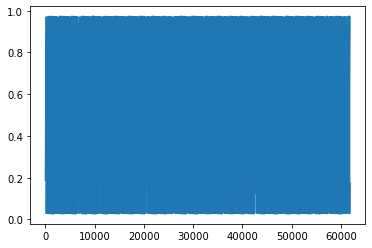

In [9]:
plt.plot(phase)

Above plot shows that phases are not sorted.

Now, let's normalize the flux

Text(0, 0.5, 'Normalized Flux')

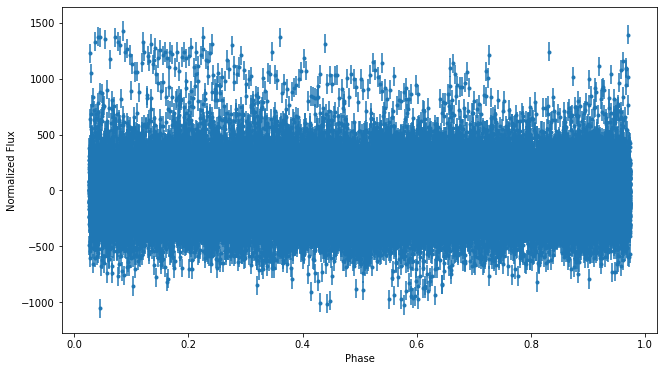

In [10]:
unbinned_flux_mean = np.mean(sc[~sc.mask].data)  # .mean()

unbinned_flux_mean_ppm = 1e6 * (unbinned_flux_mean - 1)
flux_normed = np.ascontiguousarray(
    1e6 * (sc[~sc.mask].data / unbinned_flux_mean - 1.0), dtype=np.float64)
flux_normed_err = np.ascontiguousarray(
    1e6 * slc.flux_err[out_of_transit][~sc.mask].value, dtype=np.float64)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(phase, flux_normed, yerr=flux_normed_err, fmt='.')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

And, binning it,

Text(0, 0.5, 'Normalized Flux')

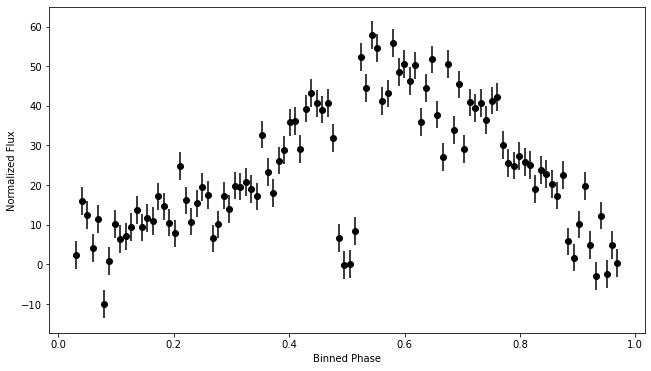

In [11]:
bins = 100
bs = binned_statistic(phase, flux_normed, statistic=np.median, bins=bins)

bs_err = binned_statistic(phase, flux_normed_err,
                          statistic=lambda x: np.median(x) / len(x) ** 0.5,
                          bins=bins)

binphase = 0.5 * (bs.bin_edges[1:] + bs.bin_edges[:-1])
binflux = bs.statistic - np.median(bs.statistic[np.abs(binphase - 0.5) < 0.01])
binerror = bs_err.statistic

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(binphase, binflux, yerr=binerror, fmt='o', c='k')
plt.xlabel('Binned Phase')
plt.ylabel('Normalized Flux')

In [12]:
f1 = open('Data/binned_data.dat', 'w')
for i in range(len(binphase)):
    f1.write(str(binphase[i]) + '\t' + str(binflux[i]) + '\t' + str(binerror[i]) + '\n')
f1.close()